In [1]:
import keras
import numpy as np
import os
import PIL
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import helpers
from pylab import imread, imshow
from skimage.color import rgb2gray
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, core , UpSampling2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from importlib import reload
helpers = reload(helpers)

Using TensorFlow backend.


In [2]:
def get_opt():
    #All parameters are defualt mentioned in paper
    return Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)



In [3]:
def encoder_conv_block_batch_norm(inputs, n_filters, dropout, kernel_size=3, batchNorm = True):
    net = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(inputs)
    if batchNorm:
        net = BatchNormalization()(net)
    net = Activation("relu")(net)
        # second layer
    net = Dropout(dropout)(net)
    net = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal", padding="same")(net)
    if batchNorm:
        net = BatchNormalization()(net)
    net = Activation("relu")(net)
    return net

In [4]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        # second layer
        x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
        padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    return x

In [5]:
def get_unet_3(dropout, input_img):
    inputs = input_img
    patch_size = 32
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(inputs)
    conv1 = Dropout(dropout)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(pool1)
    conv2 = Dropout(dropout)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_last')(pool2)
    conv3 = Dropout(dropout)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv3)

    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([conv2,up1])
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(up1)
    conv4 = Dropout(dropout)(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv4)
    #
    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([conv1,up2])
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(up2)
    conv5 = Dropout(dropout)(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv5)
    #
    conv6 = Conv2D(2, (1, 1), activation='relu',padding='same',data_format='channels_last')(conv5)
    conv6 = core.Reshape((2,32*32))(conv6)
    conv6 = core.Permute((2,1))(conv6)
    ############
    conv7 = core.Activation('softmax')(conv6)

    model = Model(inputs=inputs, outputs=conv7)
    opt  = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer = opt, loss = 'binary_crossentropy')
    return model

In [6]:
def unet_gen(dropout, input_img, transposedConv, n_filters = 32):
    inputs = input_img
    patch_size = 32
    block1 = encoder_conv_block_batch_norm(inputs, n_filters =n_filters,
                                  kernel_size=3, dropout = dropout*0.5)
    pool1 = MaxPooling2D((2, 2))(block1)
    #conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(inputs)
    #conv1 = Dropout(dropout)(conv1)
    #conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv1)
    #pool1 = MaxPooling2D((2, 2))(conv1)
    #
    block2 = encoder_conv_block_batch_norm(pool1, n_filters = n_filters*2,
                                  kernel_size=3, dropout = dropout)
    pool2 = MaxPooling2D((2, 2))(block2) 
    #conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(pool1)
    #conv2 = Dropout(dropout)(conv2)
    #conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv2)
    #pool2 = MaxPooling2D((2, 2))(conv2)
    #
    bridge = encoder_conv_block_batch_norm(pool2, n_filters = n_filters*4,
                                  kernel_size=3, dropout = dropout)
    
    #conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_last')(pool2)
    #conv3 = Dropout(dropout)(conv3)
    #conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv3)
    up1 = bridge
    if transposedConv:
        up1 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (up1)
    else:
        up1 = UpSampling2D(size=(2, 2))(up1)
    up1 = concatenate([block2,up1])
    up_block2 = encoder_conv_block_batch_norm(up1, n_filters = n_filters*2,
                                  kernel_size=3, dropout= dropout)
    
    #conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(up1)
    #conv4 = Dropout(dropout)(conv4)
    #conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv4)
    #
    up2 = up_block2
    if transposedConv:
        up2 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (up2)
    else:
        up2 = UpSampling2D(size=(2, 2))(up2)
    up2 = concatenate([block1,up2])
    up_block1 = encoder_conv_block_batch_norm(up2, n_filters = n_filters,
                                  kernel_size=3, dropout = dropout)
    #conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(up2)
    #conv5 = Dropout(dropout)(conv5)
    #conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv5)
    #
    outputs = Conv2D(1, (1, 1), activation='sigmoid',padding='same')(up_block1)
    #conv6 = core.Reshape((2,32*32))(conv6)
    #conv6 = core.Permute((2,1))(conv6)
    ############
    #conv7 = core.Activation('softmax')(conv6)
    opt = get_opt()
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer = opt, loss = 'binary_crossentropy')
    return model

In [7]:
def get_transp_conv_unet(dropout, input_img):
    return unet_gen(dropout = dropout, input_img = input_img, transposedConv = True)

In [8]:
def get_up_sample_unet(dropout, input_img):
    return unet_gen(dropout = dropout, input_img = input_img, transposedConv = False)

In [9]:
def get_unet_seismic(input_img, dropout, n_filters=16, batchnorm=True):
    # contracting path
    print("SEISMIC UNET")
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout)(p1)
    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)
    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)
    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    opt  = get_opt()
    model.compile(optimizer = opt, loss = 'binary_crossentropy')
    return model

In [39]:
def load_images_from_folder(folder_path):
    file_names = os.listdir(folder_path)
    file_names.sort()
    images = []
    for filename in file_names:
        try:
            image =imread(folder_path + filename)
            images.append(rgb2gray(image).reshape(32,32,1))
        except:
            continue
    return images

In [11]:
def generator(x_train, y_train, batch_size):
    data_gen = ImageDataGenerator(
        horizontal_flip = True, vertical_flip = True,
    ).flow(x_train, x_train, batch_size, seed=1)
    mask_gen = ImageDataGenerator(
        horizontal_flip = True, vertical_flip = True
    ).flow(y_train, y_train, batch_size, seed=1)
    while True:
        x_batch, _ = data_gen.next()
        y_batch, _ = mask_gen.next()
        yield x_batch, y_batch

## Test data augmentation function

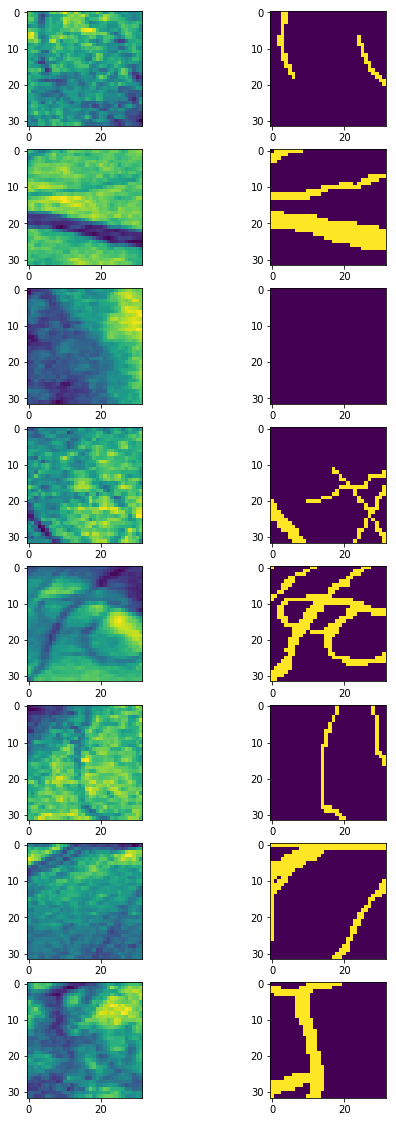

In [25]:

X_train = np.array(load_images_from_folder("../../data/DRIVE/training/patches/"))
y_train = np.array(load_images_from_folder("../../data/DRIVE/training/patchLabels/"))
image_batch, mask_batch = next(generator(X_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0])
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

In [61]:
def train(epochs, n_folds, model_dict, saveModel = False):
    X = load_images_from_folder("../../data/CHASEDB1/patches/")
    y = load_images_from_folder("../../data/CHASEDB1/patchLabels/")
    X1 = load_images_from_folder("../../data/DRIVE/training/patches/")
    y1 = load_images_from_folder("../../data/DRIVE/training/patchLabels/")
    
    X = np.array(X + X1)
    y = np.array(y + y1)
    '''
    X = np.array(load_images_from_folder("../../data/CHASEDB1/patches/"))
    y = np.array(load_images_from_folder("../../data/CHASEDB1/patchLabels/")) '''
    load_model = model_dict['load_model']
    args = model_dict['args']
    model = load_model(**args)
    batch_size = 32
    historyList =[]
    pathToSaveModel = "../../savedModels/"
    if saveModel:
        #if we cant save then we crash here
        model.save(pathToSaveModel + "test.h5")
    if n_folds > 0:
        if (len(X) % n_folds) != 0:
            raise Exception('Same eye in validation and traning set, Patches: ', X_train.shape[1], ' Folds', n_folds)
        sizeFold = len(X) // n_folds
        fold_idx = []
        for fold in range(n_folds):
            for curIdx in range(sizeFold):
                fold_idx.append(fold)
        fold_idx = np.array(fold_idx)
    
        for fold in range(n_folds):
            train_idx = fold_idx != fold
            test_idx = fold_idx == fold
            X_train = X[train_idx]
            y_train = y[train_idx]
            X_test = X[test_idx]
            y_test = y[test_idx]
            model = load_model(**args)
            earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
            mcp_save = ModelCheckpoint('.mdl_wtsPL.hdf5', save_best_only=True, monitor='val_loss', mode='min')
            #reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, verbose=1, epsilon=1e-4, mode='min')
            history = model.fit_generator(generator(X_train, y_train, batch_size = batch_size),
                                  epochs = epochs, steps_per_epoch = len(X_train)//batch_size,
                                          callbacks=[earlyStopping, mcp_save],
                                             validation_data = (X_test,y_test))
            historyList.append(history)
    elif saveModel or (n_folds == 0):
        model = load_model(**args)
        history = model.fit_generator(generator(X, y, batch_size = batch_size),
                                      epochs = epochs, steps_per_epoch = len(X)//batch_size)
        historyList.append(history)
        if saveModel:
            model.save(pathToSaveModel+model_dict['name']+".h5")
    return model, historyList
    

## Train model on the full data set, no cross validation

In [62]:
args1 = {'input_img' : Input((32,32,1)), 'dropout' : 0.2}
model_dict = {'load_model' : get_transp_conv_unet, 'args' : args1}
drive_chase_model, historyList = train(epochs = 100, n_folds = 0, model_dict = model_dict)


Epoch 1/100
150/150 [==============================] - 12s 82ms/step - loss: 0.4899 0s - loss: 0.4
Epoch 2/100
150/150 [==============================] - 5s 33ms/step - loss: 0.3979
Epoch 3/100
150/150 [==============================] - 5s 33ms/step - loss: 0.3868
Epoch 4/100
150/150 [==============================] - 5s 32ms/step - loss: 0.3805
Epoch 5/100
150/150 [==============================] - 5s 33ms/step - loss: 0.3754
Epoch 6/100
150/150 [==============================] - 5s 32ms/step - loss: 0.3731
Epoch 7/100
150/150 [==============================] - 5s 32ms/step - loss: 0.3699
Epoch 8/100
150/150 [==============================] - 5s 32ms/step - loss: 0.3674
Epoch 9/100
150/150 [==============================] - 5s 32ms/step - loss: 0.3667
Epoch 10/100
150/150 [==============================] - 5s 33ms/step - loss: 0.3654
Epoch 11/100
150/150 [==============================] - 5s 32ms/step - loss: 0.3634
Epoch 12/100
150/150 [==============================] - 5s 32ms/step 

150/150 [==============================] - 5s 31ms/step - loss: 0.3433
Epoch 98/100
150/150 [==============================] - 5s 31ms/step - loss: 0.3439
Epoch 99/100
150/150 [==============================] - 5s 31ms/step - loss: 0.3433
Epoch 100/100
150/150 [==============================] - 5s 31ms/step - loss: 0.3433


## Compare 3 models with different dropout

In [28]:
def train_3_models_dropout():
    epochs = 1
    model_name = ["TranspConv", "Seismic", "UpSample"]

    load_model = [get_transp_conv_unet, get_unet_seismic, get_up_sample_unet]

    dropouts = [0]

    model_dicts = []
    for dropout in dropouts:
        for model_idx in range(len(model_name)):
            arg = {}
            arg['dropout'] = dropout
            arg['input_img'] = Input((32,32,1))
            model_dict = {}
            model_dict['load_model'] = load_model[model_idx]
            model_dict['args'] = arg
            model_dict['name'] = model_name[model_idx] + str(dropout)
            model_dicts.append(model_dict)


    models = []
    historyLists =[]
    for model_dict in model_dicts:
        print(model_dict['name'])
        model, historyList = train(epochs = epochs, n_folds = 2, model_dict = model_dict)
        models.append(model)
        historyLists.append(historyList)
    return historyLists, model_dicts,models

In [29]:
#historyLists, model_dicts, models = train_3_models_dropout()

In [55]:
def plotMultipleModels(full_model_history_df):
    plt.style.use('ggplot')
    ax = sns.lineplot(x="epochs", y="loss", style="type", hue= 'model', data=full_model_history_df, ci = None)
    legend = ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])
    %config InlineBackend.figure_format = 'retina'
    ax.legend(loc='upper center', bbox_to_anchor= (1.11, 1), shadow=True, fontsize = 'large')
    #ax.set_ylim(0.32,0.4)
    ax.set_title('TranspConv vs Transf1er Learning', fontSize = 18)
    ax.set_xlabel('epochs',fontSize = 14)
    ax.set_ylabel('loss', fontSize = 14)
    sns.set(rc={'figure.figsize':(14,11)})
    ax.set_ylim(0.36,0.38)
    #ax.set_xlim(10,50)

    plt.show()


In [34]:
def plotComparisonOfModels( historyLists, model_dicts):
    full_model_history_df = pd.DataFrame()
    for cur_model_nr in range(len(model_dicts)):
        loss_data = ([i.history['loss'] for i in historyLists[cur_model_nr]])
        val_loss_data = ([i.history['val_loss'] for i in historyLists[cur_model_nr]])
        all_data = loss_data + val_loss_data
        all_data.append( [i+1 for i in range(len(historyLists[cur_model_nr][0].history['val_loss']))])
        model_history_df = pd.DataFrame(all_data).T
        column_names = []
        foldLossName = []
        for i in range(len(loss_data)):
            foldLossName.append("fold"+str(i)+"_loss")
        column_names += foldLossName
        foldValLossName = []
        for i in range(len(val_loss_data)):
            foldValLossName.append("fold"+str(i)+"val_loss")
        column_names += foldValLossName
        column_names.append('epochs')
        model_history_df.columns=column_names
        model_history_df["model"] = model_dicts[cur_model_nr]['name']
        #plt.plot(history.history['loss'])
        #plt.plot(history.history['val_loss'])
        #plt.xlabel("epoch")
        #plt.ylabel("loss")
        #plt.show()
        model_history_df = pd.melt(model_history_df, value_vars=foldLossName+ foldValLossName,
                                   id_vars = ['epochs','model'] ,value_name = "loss")
        types = ['train', 'validation']
        trainOrValidation = []
        for i in types:
            for j in range(model_history_df.shape[0]//2):
                trainOrValidation.append(i)
        model_history_df['type'] =trainOrValidation
        model_history_df = model_history_df.astype({'epochs': int})
        full_model_history_df = pd.concat([full_model_history_df, model_history_df], ignore_index = True)
    full_model_history_df.to_pickle("fullModelHistorydf.pkl")
    plotMultipleModels(full_model_history_df)


In [32]:
plotComparisonOfModels(historyLists, model_dicts)

NameError: name 'historyLists' is not defined

In [38]:
def best_model_more_detailed():
    epochs = 150
    model_name = ["TranspConv", "UpSample"]

    load_model = [get_transp_conv_unet, get_up_sample_unet]

    dropouts = [0.05, 0.2]
    model_dicts = []
    for dropout in dropouts:
        for model_idx in range(len(model_name)):
            arg = {}
            arg['dropout'] = dropout
            arg['input_img'] = Input((32,32,1))
            model_dict = {}
            model_dict['load_model'] = load_model[model_idx]
            model_dict['args'] = arg
            model_dict['name'] = model_name[model_idx] + str(dropout)
            model_dicts.append(model_dict)
    models = []
    historyLists =[]
    for model_dict in model_dicts:
        print(model_dict['name'])
        model, historyList = train(epochs = epochs, n_folds = 4, model_dict = model_dict)
        models.append(model)
        historyLists.append(historyList)
    return historyLists, model_dicts, models

In [39]:
historyLists_detail, model_dicts_detail, models_detail = best_model_more_detailed()

TranspConv0.05
Epoch 1/150
46/46 [==============================] - 7s 154ms/step - loss: 0.5032 - val_loss: 0.5532
Epoch 2/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3959 - val_loss: 0.5084
Epoch 3/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3811 - val_loss: 0.4740
Epoch 4/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3785 - val_loss: 0.4083
Epoch 5/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3728 - val_loss: 0.4177
Epoch 6/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3748 - val_loss: 0.4009
Epoch 7/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3694 - val_loss: 0.3823
Epoch 8/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3696 - val_loss: 0.3946
Epoch 9/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3687 - val_loss: 0.3922
Epoch 10/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3653 - 

46/46 [==============================] - 1s 32ms/step - loss: 0.3442 - val_loss: 0.3706
Epoch 83/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3441 - val_loss: 0.3750
Epoch 84/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3460 - val_loss: 0.3685
Epoch 85/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3431 - val_loss: 0.3705
Epoch 86/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3439 - val_loss: 0.3738
Epoch 87/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3434 - val_loss: 0.3704
Epoch 88/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3440 - val_loss: 0.3714
Epoch 89/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3425 - val_loss: 0.3711
Epoch 90/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3425 - val_loss: 0.3711
Epoch 91/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3419 - val_loss: 0.3692
Epo

Epoch 13/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3697 - val_loss: 0.3640
Epoch 14/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3691 - val_loss: 0.3632
Epoch 15/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3677 - val_loss: 0.3610
Epoch 16/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3668 - val_loss: 0.3609
Epoch 17/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3665 - val_loss: 0.3600
Epoch 18/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3654 - val_loss: 0.3591
Epoch 19/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3657 - val_loss: 0.3580
Epoch 20/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3630 - val_loss: 0.3624
Epoch 21/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3636 - val_loss: 0.3629
Epoch 22/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3632 - val_los

46/46 [==============================] - 1s 32ms/step - loss: 0.3440 - val_loss: 0.3606
Epoch 95/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3438 - val_loss: 0.3598
Epoch 96/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3442 - val_loss: 0.3593
Epoch 97/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3433 - val_loss: 0.3602
Epoch 98/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3431 - val_loss: 0.3595
Epoch 99/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3428 - val_loss: 0.3611
Epoch 100/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3431 - val_loss: 0.3634
Epoch 101/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3420 - val_loss: 0.3591
Epoch 102/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3425 - val_loss: 0.3608
Epoch 103/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3429 - val_loss: 0.3631

Epoch 25/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3584 - val_loss: 0.3715
Epoch 26/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3562 - val_loss: 0.3700
Epoch 27/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3582 - val_loss: 0.3722
Epoch 28/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3558 - val_loss: 0.3699
Epoch 29/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3574 - val_loss: 0.3706
Epoch 30/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3560 - val_loss: 0.3725
Epoch 31/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3551 - val_loss: 0.3729
Epoch 32/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3554 - val_loss: 0.3698
Epoch 33/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3542 - val_loss: 0.3704
Epoch 34/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3551 - val_los

46/46 [==============================] - 1s 32ms/step - loss: 0.3373 - val_loss: 0.3741
Epoch 107/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3377 - val_loss: 0.3757
Epoch 108/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3374 - val_loss: 0.3754
Epoch 109/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3371 - val_loss: 0.3746
Epoch 110/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3366 - val_loss: 0.3738
Epoch 111/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3366 - val_loss: 0.3740
Epoch 112/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3360 - val_loss: 0.3773
Epoch 113/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3372 - val_loss: 0.3742
Epoch 114/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3355 - val_loss: 0.3768
Epoch 115/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3370 - val_loss: 0

Epoch 37/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3553 - val_loss: 0.3630
Epoch 38/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3554 - val_loss: 0.3612
Epoch 39/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3549 - val_loss: 0.3622
Epoch 40/150
46/46 [==============================] - 2s 33ms/step - loss: 0.3548 - val_loss: 0.3600
Epoch 41/150
46/46 [==============================] - 2s 34ms/step - loss: 0.3550 - val_loss: 0.3638
Epoch 42/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3550 - val_loss: 0.3620
Epoch 43/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3528 - val_loss: 0.3639
Epoch 44/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3539 - val_loss: 0.3642
Epoch 45/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3545 - val_loss: 0.3628
Epoch 46/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3528 - val_los

Epoch 118/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3367 - val_loss: 0.3708
Epoch 119/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3372 - val_loss: 0.3650
Epoch 120/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3362 - val_loss: 0.3674
Epoch 121/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3363 - val_loss: 0.3672
Epoch 122/150
46/46 [==============================] - 2s 33ms/step - loss: 0.3368 - val_loss: 0.3662
Epoch 123/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3359 - val_loss: 0.3684
Epoch 124/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3364 - val_loss: 0.3669
Epoch 125/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3344 - val_loss: 0.3663
Epoch 126/150
46/46 [==============================] - 2s 33ms/step - loss: 0.3361 - val_loss: 0.3660
Epoch 127/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3353

Epoch 129/150
46/46 [==============================] - 1s 31ms/step - loss: 0.3359 - val_loss: 0.3736
Epoch 130/150
46/46 [==============================] - 1s 31ms/step - loss: 0.3360 - val_loss: 0.3742
Epoch 131/150
46/46 [==============================] - 1s 31ms/step - loss: 0.3352 - val_loss: 0.3767
Epoch 132/150
46/46 [==============================] - 1s 30ms/step - loss: 0.3351 - val_loss: 0.3736
Epoch 133/150
46/46 [==============================] - 1s 30ms/step - loss: 0.3356 - val_loss: 0.3723
Epoch 134/150
46/46 [==============================] - 1s 31ms/step - loss: 0.3354 - val_loss: 0.3742
Epoch 135/150
46/46 [==============================] - 1s 31ms/step - loss: 0.3352 - val_loss: 0.3725
Epoch 136/150
46/46 [==============================] - 1s 31ms/step - loss: 0.3355 - val_loss: 0.3746
Epoch 137/150
46/46 [==============================] - 1s 31ms/step - loss: 0.3347 - val_loss: 0.3743
Epoch 138/150
46/46 [==============================] - 1s 30ms/step - loss: 0.3352

Epoch 60/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3530 - val_loss: 0.3570
Epoch 61/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3519 - val_loss: 0.3564
Epoch 62/150
46/46 [==============================] - 1s 31ms/step - loss: 0.3514 - val_loss: 0.3563
Epoch 63/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3517 - val_loss: 0.3569
Epoch 64/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3510 - val_loss: 0.3566
Epoch 65/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3519 - val_loss: 0.3568
Epoch 66/150
46/46 [==============================] - 1s 31ms/step - loss: 0.3508 - val_loss: 0.3564
Epoch 67/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3496 - val_loss: 0.3584
Epoch 68/150
46/46 [==============================] - 1s 31ms/step - loss: 0.3513 - val_loss: 0.3569
Epoch 69/150
46/46 [==============================] - 1s 31ms/step - loss: 0.3505 - val_los

46/46 [==============================] - 1s 31ms/step - loss: 0.3463 - val_loss: 0.3709
Epoch 72/150
46/46 [==============================] - 1s 30ms/step - loss: 0.3466 - val_loss: 0.3706
Epoch 73/150
46/46 [==============================] - 1s 30ms/step - loss: 0.3461 - val_loss: 0.3712
Epoch 74/150
46/46 [==============================] - 1s 30ms/step - loss: 0.3464 - val_loss: 0.3707
Epoch 75/150
46/46 [==============================] - 1s 30ms/step - loss: 0.3450 - val_loss: 0.3704
Epoch 76/150
46/46 [==============================] - 1s 30ms/step - loss: 0.3471 - val_loss: 0.3714
Epoch 77/150
46/46 [==============================] - 1s 31ms/step - loss: 0.3446 - val_loss: 0.3731
Epoch 78/150
46/46 [==============================] - 1s 30ms/step - loss: 0.3461 - val_loss: 0.3725
Epoch 79/150
46/46 [==============================] - 1s 30ms/step - loss: 0.3442 - val_loss: 0.3742
Epoch 80/150
46/46 [==============================] - 1s 31ms/step - loss: 0.3465 - val_loss: 0.3715
Epo

46/46 [==============================] - 1s 31ms/step - loss: 0.3450 - val_loss: 0.3633
Epoch 83/150
46/46 [==============================] - 1s 31ms/step - loss: 0.3455 - val_loss: 0.3643
Epoch 84/150
46/46 [==============================] - 1s 31ms/step - loss: 0.3457 - val_loss: 0.3617
Epoch 85/150
46/46 [==============================] - 1s 31ms/step - loss: 0.3438 - val_loss: 0.3617
Epoch 86/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3452 - val_loss: 0.3623
Epoch 87/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3453 - val_loss: 0.3652
Epoch 88/150
46/46 [==============================] - 1s 31ms/step - loss: 0.3448 - val_loss: 0.3655
Epoch 89/150
46/46 [==============================] - 1s 31ms/step - loss: 0.3441 - val_loss: 0.3662
Epoch 90/150
46/46 [==============================] - 1s 32ms/step - loss: 0.3441 - val_loss: 0.3643
Epoch 91/150
46/46 [==============================] - 1s 31ms/step - loss: 0.3436 - val_loss: 0.3665
Epo

46/46 [==============================] - 2s 35ms/step - loss: 0.3494 - val_loss: 0.3673
Epoch 94/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3490 - val_loss: 0.3687
Epoch 95/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3494 - val_loss: 0.3692
Epoch 96/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3492 - val_loss: 0.3655
Epoch 97/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3486 - val_loss: 0.3672
Epoch 98/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3489 - val_loss: 0.3652
Epoch 99/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3479 - val_loss: 0.3658
Epoch 100/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3488 - val_loss: 0.3671
Epoch 101/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3481 - val_loss: 0.3652
Epoch 102/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3473 - val_loss: 0.3665


Epoch 24/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3643 - val_loss: 0.3586
Epoch 25/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3659 - val_loss: 0.3600
Epoch 26/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3626 - val_loss: 0.3571
Epoch 27/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3648 - val_loss: 0.3609
Epoch 28/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3636 - val_loss: 0.3603
Epoch 29/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3644 - val_loss: 0.3575
Epoch 30/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3612 - val_loss: 0.3584
Epoch 31/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3631 - val_loss: 0.3565
Epoch 32/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3622 - val_loss: 0.3595
Epoch 33/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3612 - val_los

Epoch 105/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3508 - val_loss: 0.3554
Epoch 106/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3492 - val_loss: 0.3577
Epoch 107/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3495 - val_loss: 0.3547
Epoch 108/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3496 - val_loss: 0.3559
Epoch 109/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3497 - val_loss: 0.3560
Epoch 110/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3505 - val_loss: 0.3550
Epoch 111/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3487 - val_loss: 0.3578
Epoch 112/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3491 - val_loss: 0.3579
Epoch 113/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3501 - val_loss: 0.3575
Epoch 114/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3488

46/46 [==============================] - 2s 35ms/step - loss: 0.3446 - val_loss: 0.3775
Epoch 117/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3467 - val_loss: 0.3667
Epoch 118/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3455 - val_loss: 0.3690
Epoch 119/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3460 - val_loss: 0.3684
Epoch 120/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3453 - val_loss: 0.3691
Epoch 121/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3451 - val_loss: 0.3693
Epoch 122/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3460 - val_loss: 0.3701
Epoch 123/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3452 - val_loss: 0.3691
Epoch 124/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3454 - val_loss: 0.3695
Epoch 125/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3443 - val_loss: 0

Epoch 47/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3568 - val_loss: 0.3609TA: 0s
Epoch 48/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3565 - val_loss: 0.3595
Epoch 49/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3561 - val_loss: 0.3592
Epoch 50/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3559 - val_loss: 0.3658
Epoch 51/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3553 - val_loss: 0.3605
Epoch 52/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3555 - val_loss: 0.3603
Epoch 53/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3555 - val_loss: 0.3607
Epoch 54/150
46/46 [==============================] - 2s 37ms/step - loss: 0.3547 - val_loss: 0.3598
Epoch 55/150
46/46 [==============================] - 2s 39ms/step - loss: 0.3557 - val_loss: 0.3628
Epoch 56/150
46/46 [==============================] - 2s 40ms/step - loss: 0.3560 - v

46/46 [==============================] - 2s 34ms/step - loss: 0.3546 - val_loss: 0.3664
Epoch 58/150
46/46 [==============================] - 2s 34ms/step - loss: 0.3554 - val_loss: 0.3670
Epoch 59/150
46/46 [==============================] - 2s 34ms/step - loss: 0.3546 - val_loss: 0.3800
Epoch 60/150
46/46 [==============================] - 2s 34ms/step - loss: 0.3547 - val_loss: 0.3667
Epoch 61/150
46/46 [==============================] - 2s 33ms/step - loss: 0.3537 - val_loss: 0.3737
Epoch 62/150
46/46 [==============================] - 2s 34ms/step - loss: 0.3546 - val_loss: 0.3667
Epoch 63/150
46/46 [==============================] - 2s 34ms/step - loss: 0.3538 - val_loss: 0.3658
Epoch 64/150
46/46 [==============================] - 2s 34ms/step - loss: 0.3537 - val_loss: 0.3665
Epoch 65/150
46/46 [==============================] - 2s 34ms/step - loss: 0.3527 - val_loss: 0.3676
Epoch 66/150
46/46 [==============================] - 2s 34ms/step - loss: 0.3540 - val_loss: 0.3650
Epo

Epoch 138/150
46/46 [==============================] - 2s 34ms/step - loss: 0.3462 - val_loss: 0.3687
Epoch 139/150
46/46 [==============================] - 2s 33ms/step - loss: 0.3459 - val_loss: 0.3697
Epoch 140/150
46/46 [==============================] - 2s 34ms/step - loss: 0.3454 - val_loss: 0.3674
Epoch 141/150
46/46 [==============================] - 2s 34ms/step - loss: 0.3454 - val_loss: 0.3658
Epoch 142/150
46/46 [==============================] - 2s 34ms/step - loss: 0.3452 - val_loss: 0.3692
Epoch 143/150
46/46 [==============================] - 2s 34ms/step - loss: 0.3453 - val_loss: 0.3684
Epoch 144/150
46/46 [==============================] - 2s 33ms/step - loss: 0.3453 - val_loss: 0.3663
Epoch 145/150
46/46 [==============================] - 2s 33ms/step - loss: 0.3443 - val_loss: 0.3679
Epoch 146/150
46/46 [==============================] - 2s 34ms/step - loss: 0.3454 - val_loss: 0.3677
Epoch 147/150
46/46 [==============================] - 2s 34ms/step - loss: 0.3452

46/46 [==============================] - 2s 34ms/step - loss: 0.3547 - val_loss: 0.3580
Epoch 70/150
46/46 [==============================] - 2s 34ms/step - loss: 0.3551 - val_loss: 0.3577
Epoch 71/150
46/46 [==============================] - 2s 34ms/step - loss: 0.3542 - val_loss: 0.3565
Epoch 72/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3553 - val_loss: 0.3551
Epoch 73/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3540 - val_loss: 0.3560
Epoch 74/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3543 - val_loss: 0.3578
Epoch 75/150
46/46 [==============================] - 2s 34ms/step - loss: 0.3540 - val_loss: 0.3574
Epoch 76/150
46/46 [==============================] - 2s 34ms/step - loss: 0.3550 - val_loss: 0.3548
Epoch 77/150
46/46 [==============================] - 2s 34ms/step - loss: 0.3521 - val_loss: 0.3573
Epoch 78/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3549 - val_loss: 0.3562
Epo

46/46 [==============================] - 2s 35ms/step - loss: 0.3516 - val_loss: 0.3701
Epoch 81/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3501 - val_loss: 0.3704
Epoch 82/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3499 - val_loss: 0.3705
Epoch 83/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3495 - val_loss: 0.3706
Epoch 84/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3510 - val_loss: 0.3691
Epoch 85/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3492 - val_loss: 0.3690
Epoch 86/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3492 - val_loss: 0.3701
Epoch 87/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3497 - val_loss: 0.3686
Epoch 88/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3495 - val_loss: 0.3692
Epoch 89/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3497 - val_loss: 0.3694
Epo

Epoch 11/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3704 - val_loss: 0.3789
Epoch 12/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3736 - val_loss: 0.3751
Epoch 13/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3710 - val_loss: 0.3730
Epoch 14/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3698 - val_loss: 0.3769
Epoch 15/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3676 - val_loss: 0.3756
Epoch 16/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3680 - val_loss: 0.3670
Epoch 17/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3666 - val_loss: 0.3675
Epoch 18/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3678 - val_loss: 0.3756
Epoch 19/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3652 - val_loss: 0.3693
Epoch 20/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3655 - val_los

46/46 [==============================] - 2s 36ms/step - loss: 0.3507 - val_loss: 0.3592
Epoch 93/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3501 - val_loss: 0.3607
Epoch 94/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3502 - val_loss: 0.3641
Epoch 95/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3499 - val_loss: 0.3609
Epoch 96/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3500 - val_loss: 0.3596
Epoch 97/150
46/46 [==============================] - 2s 36ms/step - loss: 0.3499 - val_loss: 0.3636
Epoch 98/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3491 - val_loss: 0.3618
Epoch 99/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3500 - val_loss: 0.3622
Epoch 100/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3498 - val_loss: 0.3635
Epoch 101/150
46/46 [==============================] - 2s 35ms/step - loss: 0.3495 - val_loss: 0.3607
E

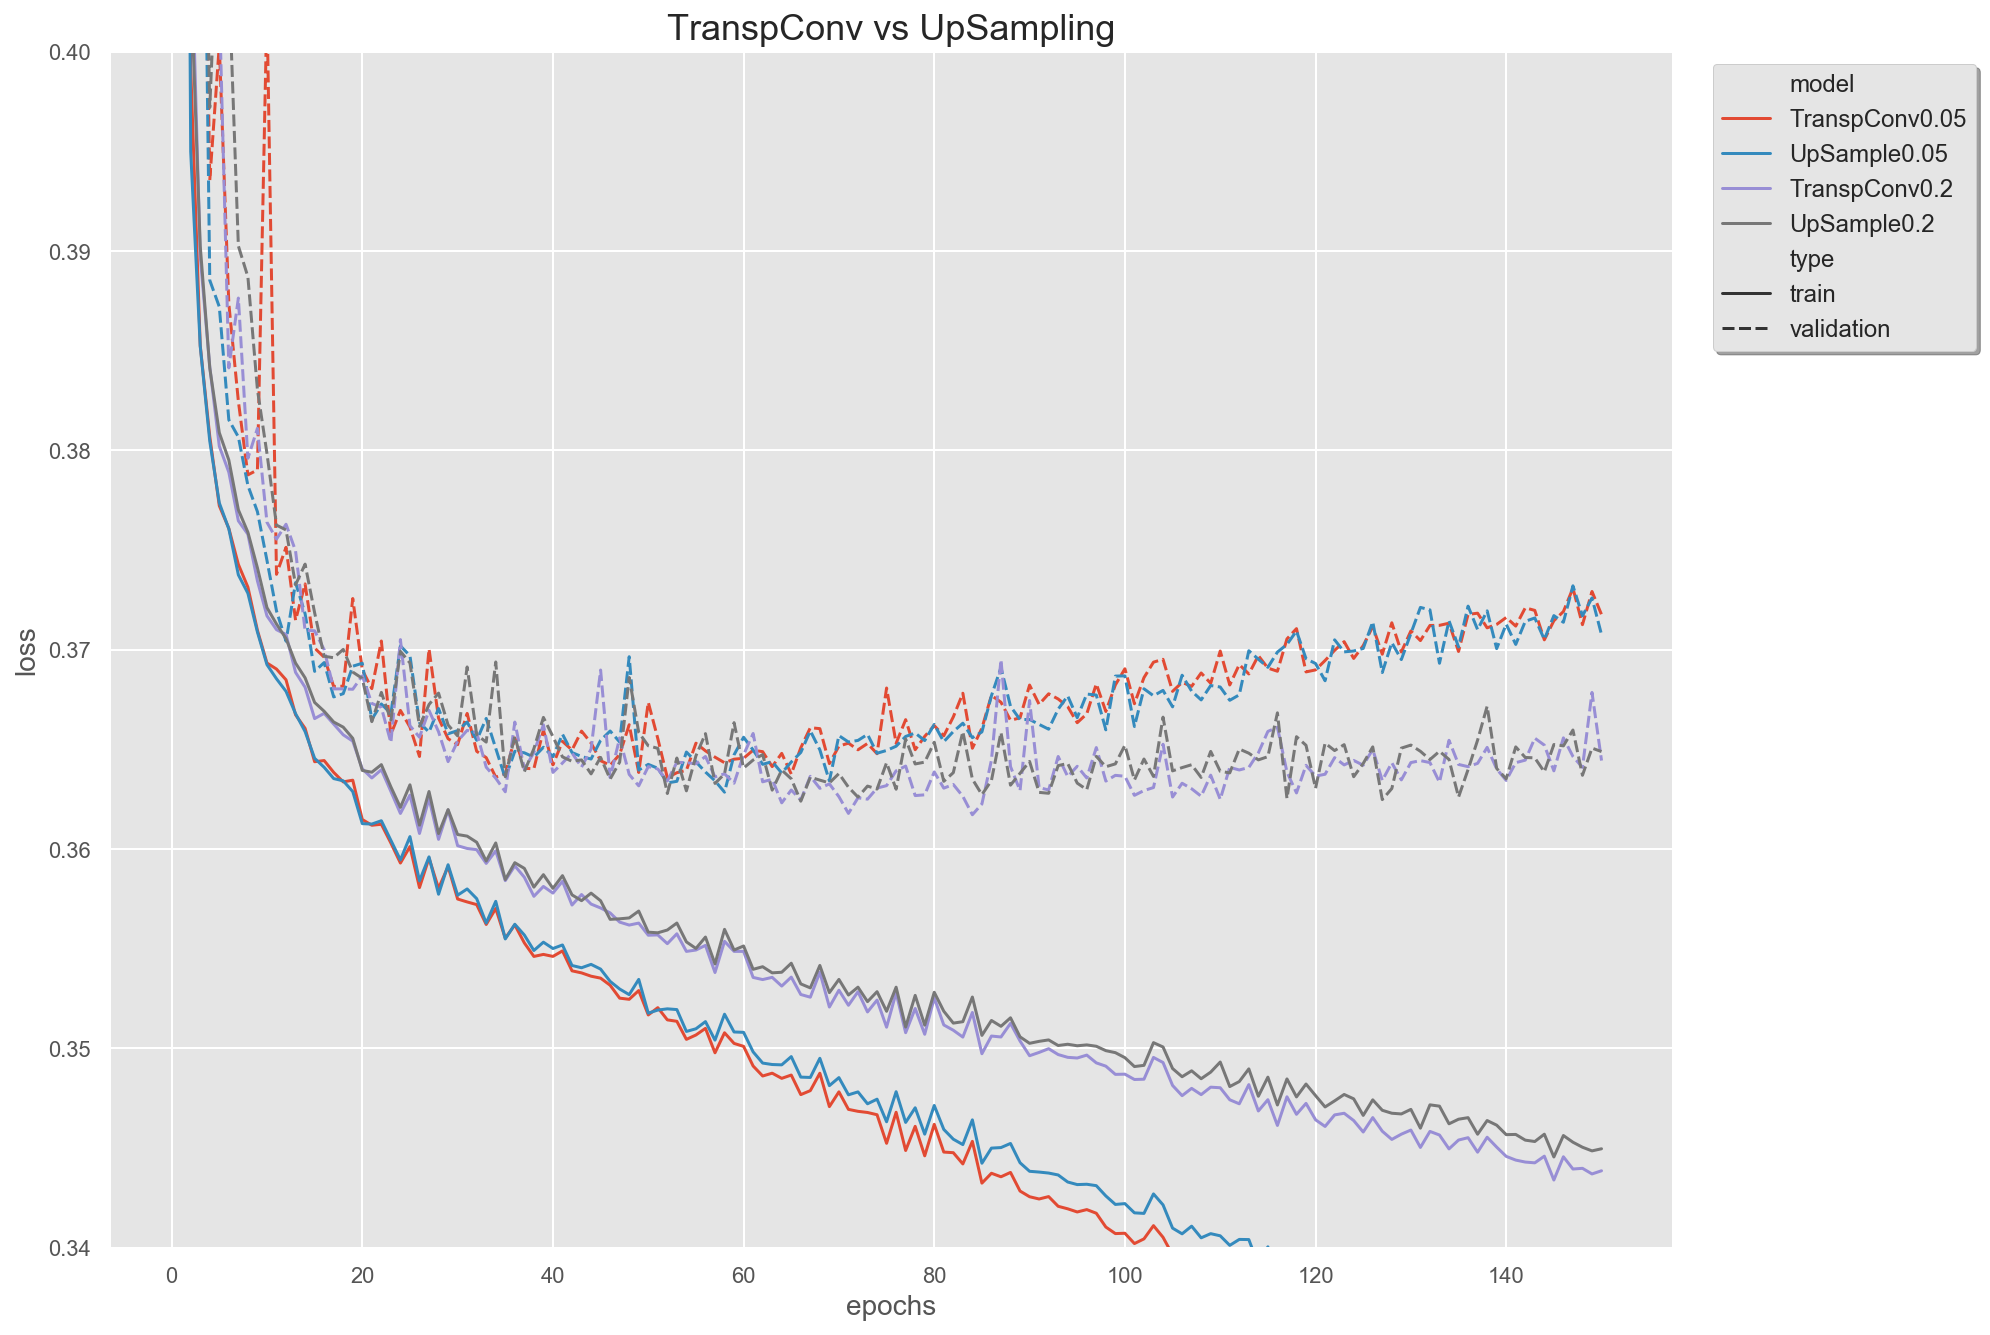

In [51]:
plotComparisonOfModels(historyLists_detail, model_dicts_detail)

In [ ]:
nr_of_images = 10
fig, ax = plt.subplots(nr_of_images,4, figsize=(8,20))
fig.tight_layout()
for image_nr in range(nr_of_images):
    ax[image_nr,0].imshow(X_train[image_nr].reshape(32,32))
    ax[image_nr,1].imshow(y_train[image_nr].reshape(32,32))
    y_pred = res.predict(X_train[image_nr:(image_nr+1)]).reshape(32,32)
    y_pred_thr = y_pred.copy()
    y_pred_thr[y_pred > 0.5] = 1
    y_pred_thr[y_pred <= 0.5] = 0
    ax[image_nr,2].imshow(y_pred)
    ax[image_nr,3].imshow(y_pred_thr)
    for j in range(4):
        ax[image_nr,j].set_xticklabels([])
        ax[image_nr,j].set_yticklabels([])
plt.show()



In [45]:
drive_test_images = helpers.load_images_from_folder(helpers.DRIVE_TEST_IMAGES_PATH)
drive_test_mask = helpers.load_images_from_folder(helpers.DRIVE_TEST_MASK_PATH)
drive_test_segmented = helpers.load_images_from_folder(helpers.DRIVE_TEST_SEG_1_PATH)

drive_training_images = helpers.load_images_from_folder(helpers.DRIVE_TRAINING_IMAGES_PATH)
drive_training_mask = helpers.load_images_from_folder(helpers.DRIVE_TRAINING_MASK_PATH)
drive_training_segmented = helpers.load_images_from_folder(helpers.DRIVE_TRAINING_SEG_1_PATH)

chase_training_images = helpers.load_images_from_folder(helpers.CHASE_IMAGES_PATH)
chase_training_mask = helpers.load_images_from_folder(helpers.CHASE_MASK_PATH)
chase_training_segmented = helpers.load_images_from_folder(helpers.CHASE_SEG_1_PATH)

In [18]:
def get_test_score(images, mask, segmentation, model, plot=False, nr_of_images=None ):
    if not nr_of_images:
        nr_of_images = len(images)
    total_auc_score = 0
    total_accuracy = 0
    total_sensitivity = 0
    total_specificity = 0
    if plot:
        fig, ax = plt.subplots(nr_of_images,3, figsize=(20,20))
    for (i, image) in enumerate(images[:nr_of_images]):
        print('Segmenting image',(i+1))
        full_image_segmentation = helpers.segment_whole_image(image, mask[i], 32, helpers.Dataset.DRIVE, model)
        total_auc_score += helpers.roc_auc(full_image_segmentation, segmentation[i], mask[i])
        total_accuracy += helpers.accuracy(full_image_segmentation, segmentation[i], mask[i])
        total_sensitivity += helpers.sensitivity(full_image_segmentation, segmentation[i], mask[i])
        total_specificity += helpers.specificity(full_image_segmentation, segmentation[i], mask[i])
        if plot:
            ax[i, 0].imshow(full_image_segmentation)
            ax[i, 1].imshow(segmentation[i])
            ax[i, 2].imshow(image)
            
    print('Average auc score: ', total_auc_score/nr_of_images)
    print('Average accuracy score: ', total_accuracy/ nr_of_images )
    print('Average sensitivity score: ', total_sensitivity/ nr_of_images )
    print('Average specificity score: ', total_specificity/nr_of_images )
    if plot:
        plt.show()
            

In [50]:
get_test_score(drive_test_images, drive_test_mask, drive_test_segmented, final_model_more_data, False, 20)

Segmenting image 1
Segmenting image 2
Segmenting image 3
Segmenting image 4
Segmenting image 5
Segmenting image 6
Segmenting image 7
Segmenting image 8
Segmenting image 9
Segmenting image 10
Segmenting image 11
Segmenting image 12
Segmenting image 13
Segmenting image 14
Segmenting image 15
Segmenting image 16
Segmenting image 17
Segmenting image 18
Segmenting image 19
Segmenting image 20
Average auc score:  0.9769535473284578
Average accuracy score:  0.9545603151266878
Average sensitivity score:  0.7566372519901075
Average specificity score:  0.9837225069921265


Segmenting image 1
Segmenting image 2
Segmenting image 3
Average auc score:  0.9780515344241355
Average accuracy score:  0.9518717264751236
Average sensitivity score:  0.7820254901050768
Average specificity score:  0.9803475186989071


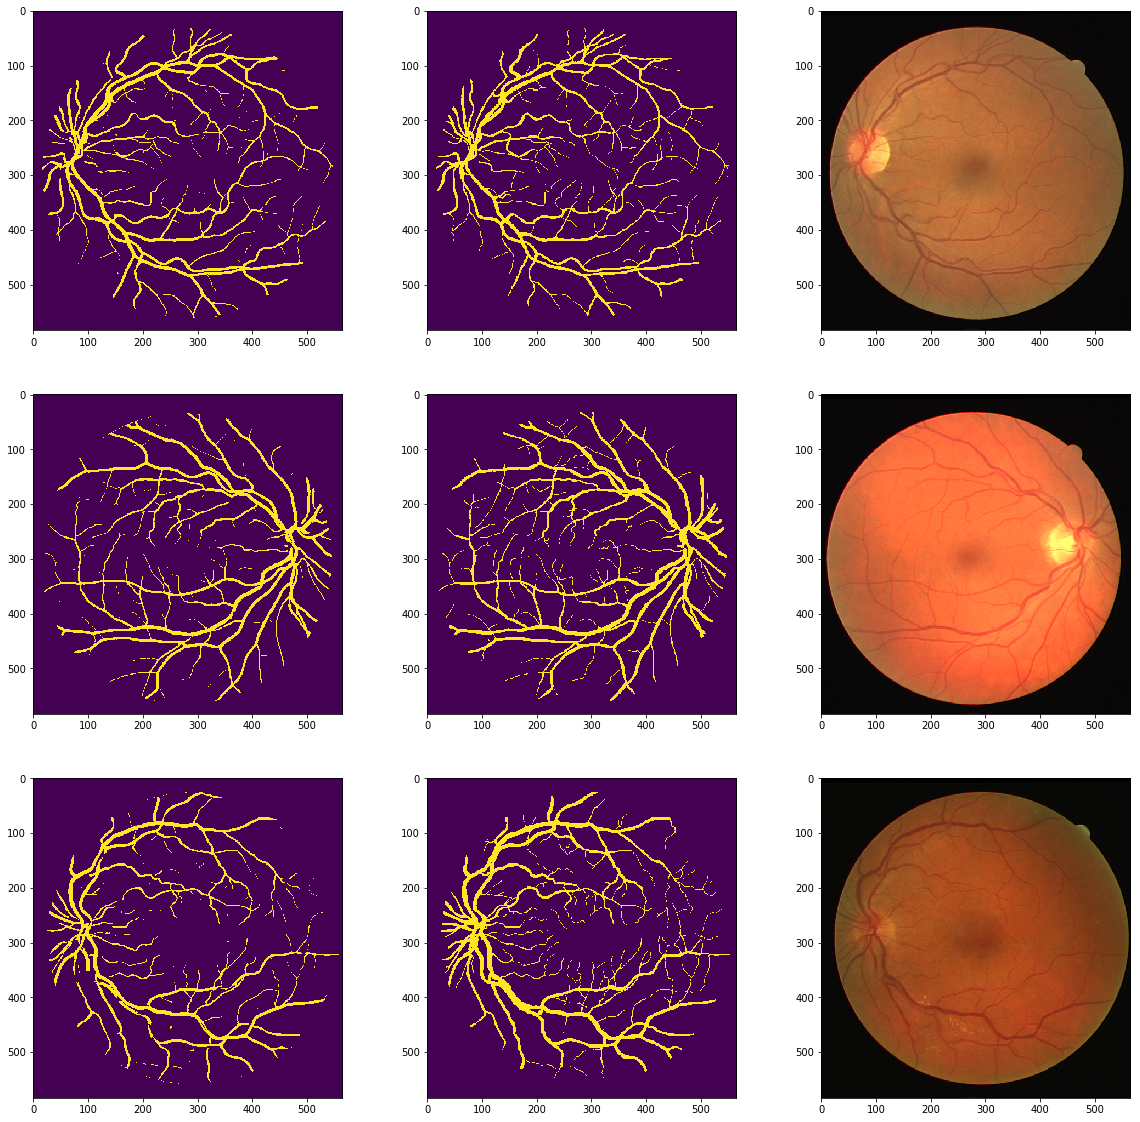

In [51]:
get_test_score(drive_test_images, drive_test_mask, drive_test_segmented, final_model_more_data, True, 3)

In [52]:
final_model_more_data.save('../../savedModels/bestLong')

Segmenting image 1
Segmenting image 2
Segmenting image 3
Average auc score:  0.9753513983360099
Average accuracy score:  0.9495991626438031
Average sensitivity score:  0.7997468974874629
Average specificity score:  0.9747896176602421


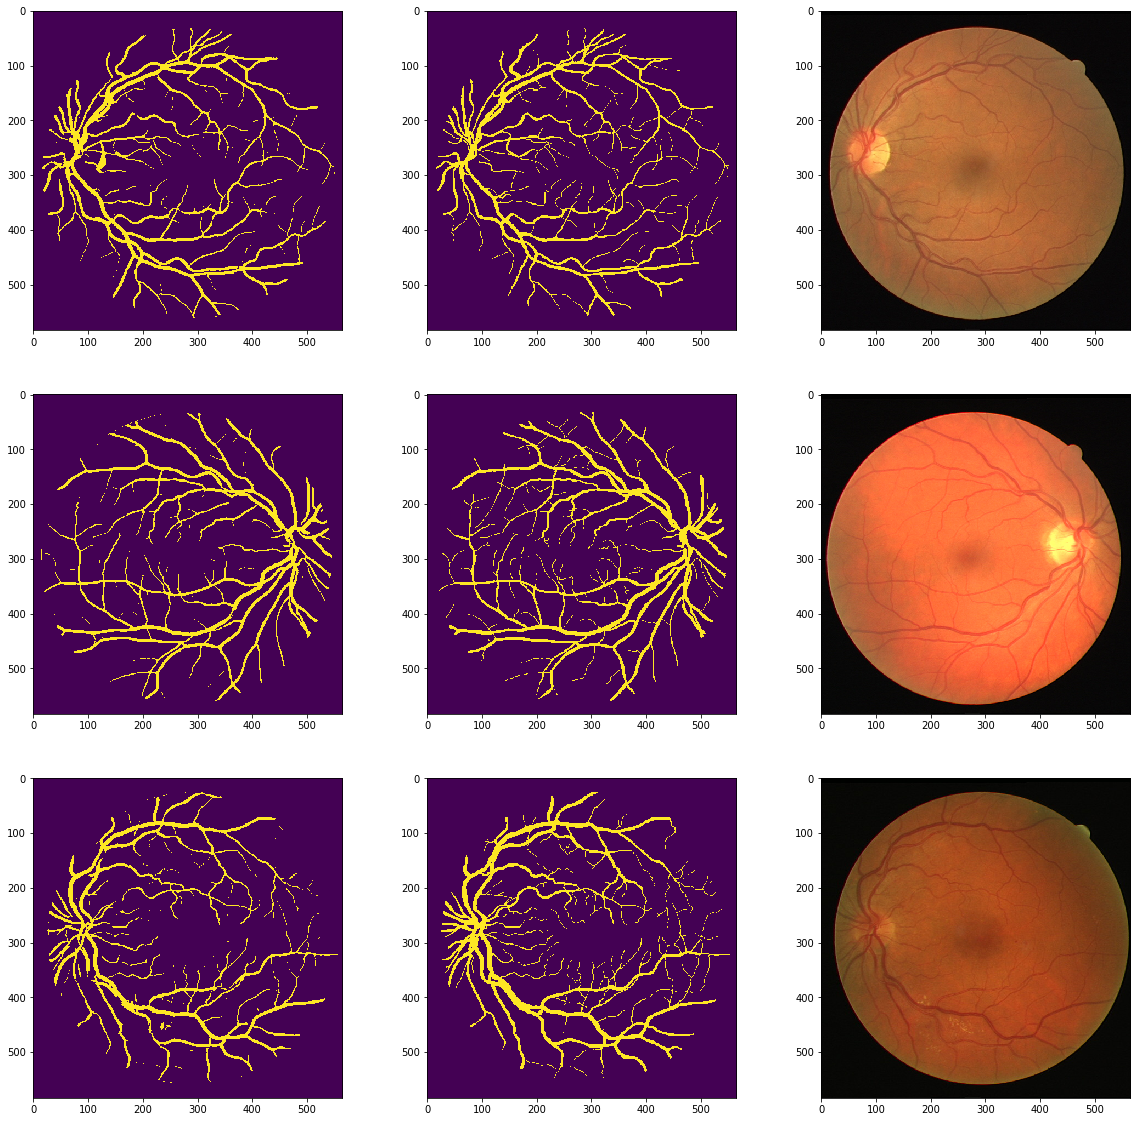

In [28]:
get_test_score(drive_test_images, drive_test_mask, drive_test_segmented, final_model_no_stop, True, 3)

In [26]:
get_test_score(drive_test_images, drive_test_mask, drive_test_segmented, final_model_no_stop, False, 20)

Segmenting image 1
Segmenting image 2
Segmenting image 3
Segmenting image 4
Segmenting image 5
Segmenting image 6
Segmenting image 7
Segmenting image 8
Segmenting image 9
Segmenting image 10
Segmenting image 11
Segmenting image 12
Segmenting image 13
Segmenting image 14
Segmenting image 15
Segmenting image 16
Segmenting image 17
Segmenting image 18
Segmenting image 19
Segmenting image 20
Average auc score:  0.9734562208164034
Average accuracy score:  0.9519570056712803
Average sensitivity score:  0.777258709242376
Average specificity score:  0.9777454394002814


In [67]:
get_test_score(drive_test_images, drive_test_mask, drive_test_segmented, transfer_model2, False, 20)

Segmenting image 1
Segmenting image 2
Segmenting image 3
Segmenting image 4
Segmenting image 5
Segmenting image 6
Segmenting image 7
Segmenting image 8
Segmenting image 9
Segmenting image 10
Segmenting image 11
Segmenting image 12
Segmenting image 13
Segmenting image 14
Segmenting image 15
Segmenting image 16
Segmenting image 17
Segmenting image 18
Segmenting image 19
Segmenting image 20
Average auc score:  0.9590025392594812
Average accuracy score:  0.9408943556439235
Average sensitivity score:  0.6781809058485401
Average specificity score:  0.9795234214096699


In [24]:
get_test_score(drive_test_images, drive_test_mask, drive_test_segmented, drive_model, False, 20)

Segmenting image 1
Segmenting image 2
Segmenting image 3
Segmenting image 4
Segmenting image 5
Segmenting image 6
Segmenting image 7
Segmenting image 8
Segmenting image 9
Segmenting image 10
Segmenting image 11
Segmenting image 12
Segmenting image 13
Segmenting image 14
Segmenting image 15
Segmenting image 16
Segmenting image 17
Segmenting image 18
Segmenting image 19
Segmenting image 20
Average auc score:  0.9688504883036517
Average accuracy score:  0.950675178566927
Average sensitivity score:  0.7688140167808004
Average specificity score:  0.9774974567811828


In [57]:
get_test_score(drive_test_images, drive_test_mask, drive_test_segmented, chase_model, False, 20)

Segmenting image 1
Segmenting image 2
Segmenting image 3
Segmenting image 4
Segmenting image 5
Segmenting image 6
Segmenting image 7
Segmenting image 8
Segmenting image 9
Segmenting image 10
Segmenting image 11
Segmenting image 12
Segmenting image 13
Segmenting image 14
Segmenting image 15
Segmenting image 16
Segmenting image 17
Segmenting image 18
Segmenting image 19
Segmenting image 20
Average auc score:  0.9310597628717847
Average accuracy score:  0.9275966827196231
Average sensitivity score:  0.5142787651877891
Average specificity score:  0.9881675440682341


In [63]:
get_test_score(drive_test_images, drive_test_mask, drive_test_segmented, drive_chase_model, False, 20)

Segmenting image 1
Segmenting image 2
Segmenting image 3
Segmenting image 4
Segmenting image 5
Segmenting image 6
Segmenting image 7
Segmenting image 8
Segmenting image 9
Segmenting image 10
Segmenting image 11
Segmenting image 12
Segmenting image 13
Segmenting image 14
Segmenting image 15
Segmenting image 16
Segmenting image 17
Segmenting image 18
Segmenting image 19
Segmenting image 20
Average auc score:  0.9715694768993858
Average accuracy score:  0.9503773872262091
Average sensitivity score:  0.7442424224546024
Average specificity score:  0.9808317065366777


In [47]:
def create_patches(images, segmentations, masks, n, patches_per_image):
    nrOfImages = 0
    for (i, image) in enumerate(images):
        patch_images, patch_labels = helpers.get_image_pathes(image, segmentations[i], n, patches_per_image, helpers.Dataset.DRIVE, masks[i])
        for (j, patch) in enumerate(patch_images):
            name = str(i) + '_' + str(j)
            helpers.save_image('../../data/DRIVE/training/patches/' + name + '.png', patch)
            helpers.save_image('../../data/DRIVE/training/patchLabels/' + name + '.png' , patch_labels[j])
            nrOfImages += 1

In [60]:
create_patches(drive_training_images, drive_training_segmented, drive_training_mask, 32, 100)

In [65]:
def transfer_train(model, epochs, layers, n_folds=0):
    transfer_model = model
    for layer in transfer_model.layers[: -8*layers]:
        layer.trainable = False
        
    opt  = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    transfer_model.compile(optimizer = opt, loss = 'binary_crossentropy')
    X = np.array(load_images_from_folder("../../data/DRIVE/training/patches/"))
    y = np.array(load_images_from_folder("../../data/DRIVE/training/patchLabels/"))
    batch_size = 32
    historyList =[]
    if n_folds > 0:
        if (len(X) % n_folds) != 0:
            raise Exception('Same eye in validation and traning set, Patches: ', X_train.shape[1], ' Folds', n_folds)
        sizeFold = len(X) // n_folds
        fold_idx = []
        for fold in range(n_folds):
            for curIdx in range(sizeFold):
                fold_idx.append(fold)
        fold_idx = np.array(fold_idx)
    
        for fold in range(n_folds):
            train_idx = fold_idx != fold
            test_idx = fold_idx == fold
            X_train = X[train_idx]
            y_train = y[train_idx]
            X_test = X[test_idx]
            y_test = y[test_idx]
            transfer_model = copy_model(model)
            for layer in transfer_model.layers[: -8*layers]:
                layer.trainable = False
            opt  = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
            transfer_model.compile(optimizer = opt, loss = 'binary_crossentropy')
            history = transfer_model.fit_generator(generator(X_train, y_train, batch_size = batch_size),
                                  epochs = epochs, steps_per_epoch = len(X_train)//batch_size,
                                         validation_data = (X_test,y_test))
            historyList.append(history)
    elif n_folds == 0:
        history = transfer_model.fit_generator(generator(X, y, batch_size = batch_size),
                                      epochs = epochs, steps_per_epoch = len(X)//batch_size)
        historyList.append(history)
    return transfer_model, historyList

In [70]:
def transfer_vs_transConv(model):
    model_dicts = []
    historyLists = []
    models = []
    epochs = 5
    frozenBlocks = [1]
    model_names = ['TransferLearningB1', 'TransferLearningB2', 'TransferLearningB3', 'TransferLearningB4']
    for model_name_idx in range(len(model_names)):
        model_transf, history_transf = transfer_train(model= model,
                                                      epochs = epochs, layers= frozenBlocks[model_name_idx], n_folds = 4)
        model_dict = {'name' : model_names[model_name_idx]}
        model_dicts.append(model_dict)
        historyLists.append(history_transf) 
        models.append(model_transf)
    return historyLists, model_dicts, models
    


In [ ]:
#historyLists_transf.append(historyLists_detail[2])
#model_dicts_transf.append(model_dicts_detail[2])
#models_transf.append(models_detail[2])
plotComparisonOfModels(historyLists_transf, model_dicts_transf)

In [66]:
transfer_model2, _ = transfer_train(chase_model, 100, 1)

Epoch 1/100
62/62 [==============================] - 8s 135ms/step - loss: 0.3929
Epoch 2/100
62/62 [==============================] - 1s 18ms/step - loss: 0.3895
Epoch 3/100
62/62 [==============================] - 1s 18ms/step - loss: 0.3860
Epoch 4/100
62/62 [==============================] - 1s 18ms/step - loss: 0.3818
Epoch 5/100
62/62 [==============================] - 1s 18ms/step - loss: 0.3791
Epoch 6/100
62/62 [==============================] - 1s 18ms/step - loss: 0.3777
Epoch 7/100
62/62 [==============================] - 1s 18ms/step - loss: 0.3757
Epoch 8/100
62/62 [==============================] - 1s 18ms/step - loss: 0.3761
Epoch 9/100
62/62 [==============================] - 1s 18ms/step - loss: 0.3734
Epoch 10/100
62/62 [==============================] - 1s 18ms/step - loss: 0.3748
Epoch 11/100
62/62 [==============================] - 1s 18ms/step - loss: 0.3735
Epoch 12/100
62/62 [==============================] - 1s 18ms/step - loss: 0.3737
Epoch 13/100
62/62 [====

In [68]:
def copy_model(model):
    model_copy= keras.models.clone_model(model)
    model_copy.build() 
    opt  = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model_copy.compile(optimizer = opt, loss = 'binary_crossentropy')
    model_copy.set_weights(model.get_weights())
    return model_copy